In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

In [8]:
MARKET_DATA_PATH = "../data/raw/market_train_df.csv"
NEWS_DATA_PATH = "../data/raw/news_train_df.csv"

In [4]:
def clean_market_data(market_df, train=True):
    '''Clean and preprocess the market data for training or testing.
    
    Parameters
    ----------
    market_df : dataframe
        See https://www.kaggle.com/c/two-sigma-financial-news/data for full 
        description of the dataframe.
    train : bool
        When true, adds the target variable to the dataframe.
    
    Returns
    -------
    dataframe 
        Cleaned market data.
    
    '''
    # Select wanted columns
    if train:
        cols = ['assetCode', 'time', 'volume', 'open', 'returnsOpenPrevMktres1',
                'returnsOpenPrevMktres10', 'returnsOpenNextMktres10']
    else:
        cols = ['assetCode', 'time', 'volume', 'open', 'returnsOpenPrevMktres1',
                'returnsOpenPrevMktres10']
    market_df = market_df.loc[:,cols]

    # Drop NA
    market_df.dropna(inplace=True)

    # Filter out stocks that cover the full time series
    series_len = market_df.time.nunique()
    market_df = market_df.groupby('assetCode') \
                         .filter(lambda x: len(x) == series_len)
    assert (market_df.groupby('assetCode').size() == series_len).all()
    
    # Normalize time
    market_df.loc[:, 'time'] = pd.to_datetime(market_df.time).dt.normalize()
    
    return market_df

In [5]:
def clean_news_data(news_df):
    '''Clean and preprocess the news data for training or testing.
    
    Parameters
    ----------
    news_df : dataframe
        See https://www.kaggle.com/c/two-sigma-financial-news/data for full 
        description of the dataframe.
    
    Returns
    -------
    dataframe 
        Cleaned news data.
    
    '''
    # Select columns and drop NA
    cols = ['time','assetCodes', 'sentimentNegative', 'sentimentNeutral', 
            'sentimentPositive', 'urgency', 'provider', 'bodySize', 'relevance']
    news_df = news_df.loc[:,cols]
    news_df.dropna(inplace=True)
    
    # Normalize time
    news_df.loc[:, 'time'] = pd.to_datetime(news_df.time).dt.normalize()
    
    # assetCodes from String to List
    news_df['assetCodes'] = news_df['assetCodes'].str.findall(f"'([\w\./]+)'")
    
    # Explode news on assetCodes
    assetCodes_expanded = list(chain(*news_df['assetCodes']))
    assetCodes_index = news_df.index.repeat(news_df['assetCodes'].apply(len))
    assert len(assetCodes_expanded) == len(assetCodes_index)
    
    assetCodes_df =  pd.DataFrame({'index': assetCodes_index, 'assetCode': assetCodes_expanded})
    news_df_exploded = news_df.merge(assetCodes_df, 'right', right_on='index', left_index=True, validate='1:m')
    news_df_exploded.drop(['assetCodes', 'index'], 1, inplace=True)

    # Compute means for same date and assetCode
    news_agg_dict = {
        'sentimentNegative':'mean',
        'sentimentNeutral':'mean',
        'sentimentPositive':'mean',
        'urgency':'mean',
        'bodySize':'mean',
        'relevance':'mean'
        }
    news_df_agg = news_df_exploded.groupby(['time', 'assetCode'], as_index=False).agg(news_agg_dict)
    
    # Add provider information
    idx = news_df_exploded.groupby(['time', 'assetCode'])['urgency'].transform(max) == news_df_exploded['urgency']
    news_df_exploded_2 = news_df_exploded[idx][['time', 'assetCode', 'provider']].drop_duplicates(['time', 'assetCode'])
    news_df_agg = news_df_agg.merge(news_df_exploded_2, 'left', ['time', 'assetCode'])
    
    # One-hot encoding provider
    ohe_provider = pd.get_dummies(news_df_agg['provider'])
    news_df_agg = pd.concat([news_df_agg, ohe_provider], axis=1).drop(['provider'], axis=1)

    return news_df_agg

In [27]:
def clean_data(market_df, news_df, train=True):
    '''Clean and preprocess the news and market data for training then merge them, to create a train set or test set.
    
    Parameters
    ----------
    market_df : dataframe
        See https://www.kaggle.com/c/two-sigma-financial-news/data for full description of the dataframe.
    news_df : dataframe
        See https://www.kaggle.com/c/two-sigma-financial-news/data for full description of the dataframe.
    train : bool
        When true, creates both the input features and the target dataframes.

    Returns
    -------
    dataframe 
        Cleaned data ready to be fed to the model. Returns both the input and the target dataframes when train=True.
    
    '''
    cleaned_market_df = clean_market_data(market_df, train)
    cleaned_news_df = clean_news_data(news_df)
    
    # Merge on market data
    df_merged = cleaned_market_df.merge(cleaned_news_df, 'left', ['time', 'assetCode'])
    
    if train:
        y = df_merged['returnsOpenNextMktres10']
        X = df_merged.drop(['returnsOpenNextMktres10'], axis=1)
        return X, y
    else:
        return df_merged

In [51]:
def EDA():
    '''Prints a brief overview of the data.
    
    Parameters
    ----------
    none

    Returns
    -------
    none
    
    '''
    print(X_train.shape, y_train.shape)
    print(y_train.head())
    print(X_train.head())
    print(X_train.info())
    print(X_train.describe())

In [82]:
def plot_asset(market, assetCode):
    '''Plots an asset's price, volatility and voume.
    
    Parameters
    ----------
    market_df : dataframe
        See https://www.kaggle.com/c/two-sigma-financial-news/data for full description of the dataframe.
    assetCode : string
        The asset code of the instrument you want to plot

    Returns
    -------
    none
    
    '''
    # Set plot style
    plt.style.use('seaborn')
    
    # Fetch the asset from data
    ass_market = market[market['assetCode'] == assetCode]
    ass_market.index = ass_market.time

    # Setup 3 subplots
    f, axs = plt.subplots(2,1, sharex=True, figsize=(12,8))
    
    # Subplot 1. Close price 
    ass_market.close.plot(ax=axs[0], color='black')
    axs[0].set_ylabel("Price")

    # Subplot 2. Volatility 
    volat_df = (ass_market.close - ass_market.open)
    (ass_market.close - ass_market.open).plot(color='darkred', ax = axs[1])
    axs[1].set_ylabel("Volatility")

    # Show all subplots with label
    f.suptitle("Asset: %s" % assetCode, fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

In [131]:
def plot_chosen_assets():
    '''Prints a group of select stocks, their price and their volatility.
    
    Parameters
    ----------
    none

    Returns
    -------
    none
    
    '''
    # Huge stocks (market cap 200BN - 1000BN)
    #plot_asset(market_train_df, "GOOGL.O") #nonsense data?
    #plot_asset(market_train_df, "AAPL.O") #randomly crashes from 2013-2015?
    #plot_asset(market_train_df, "FB.O") #Facebook: correct, verified, unpredictable volatility
    plot_asset(market_train_df, "INTC.O") #Intel: correct, verified, fair constant volatility
    plot_asset(market_train_df, "WFC.N") #Wells Fargo: correct, verified, crash volatility
    plot_asset(market_train_df, "AMZN.O") #Amazon: correct, verified, increasing volatility
    
    # SMEs (5-20Bn MC)
    #plot_asset(market_train_df, "ADI.N") #Analogue Devices (32Bn MC): kinda correct (one weird correction), verified
    #plot_asset(market_train_df, "NATI.O") #NI (6Bn MC): kinda correct (one weird correction in middle), verified
    plot_asset(market_train_df, "A.N") #Agilent Tech (20Bn MC): kinda correct (one weird correction toward end), verified
        
    # Small stocks (MC < 1Bn)
    #plot_asset(market_train_df, "ANDE.O") #Andersons (900M MC): unverified, high vol
    #plot_asset(market_train_df, "ALO.N") #Alio Gold (90M MC): unverified, low vol
    plot_asset(market_train_df, "BHE.N") #Benchmark Electronics (1Bn MC): verified, low vol


In [138]:
def extract_stock(X_train, y_train, assetCode):
    '''Extracts the training data for a particular asset
    
    Parameters
    ----------
    X_train : pandas dataframe containing all the assets' training data
    y_train : pandas dataframe containing all the assets' labels
    assetCode: asset code of asset to be extracted 

    Returns
    -------
    X_train_asset : pandas dataframe containing data for only the chosen assetCode
    y_train_asset : pandas dataframe containing label for only the chosen assetCode
    '''
    X_train_asset = X_train[X_train['assetCode']==assetCode]
    y_train_asset = X_train.join(y_train)
    y_train_asset = y_train_asset[y_train_asset['assetCode']==assetCode]
    y_train_asset = y_train_asset.T.tail(1)
    
    return X_train_asset, y_train_asset

In [95]:
market_train_df = pd.read_csv(MARKET_DATA_PATH)
news_train_df = pd.read_csv(NEWS_DATA_PATH)
X_train, y_train = clean_data(market_train_df, news_train_df)

print("Data cleaned!") #can take a while

Data cleaned!


In [96]:
EDA()

(1298736, 42) (1298736,)
0   -0.029993
1   -0.028244
2   -0.014505
3    0.017172
4    0.022841
Name: returnsOpenNextMktres10, dtype: float64
  assetCode       time      volume    open  returnsOpenPrevMktres1  \
0       A.N 2007-02-15   4095135.0  32.990               -0.001572   
1     AAP.N 2007-02-15   3884400.0  37.000               -0.019388   
2    AAPL.O 2007-02-15  12997017.0  85.310                0.000738   
3     ABB.N 2007-02-15  10168100.0  18.245               -0.026040   
4     ABC.N 2007-02-15   1683900.0  54.180               -0.007728   

   returnsOpenPrevMktres10  sentimentNegative  sentimentNeutral  \
0                 0.007461           0.183994          0.564769   
1                -0.026448           0.173526          0.570563   
2                -0.044809           0.027258          0.353779   
3                -0.010927           0.091920          0.332099   
4                 0.048016                NaN               NaN   

   sentimentPositive   urgency ... 

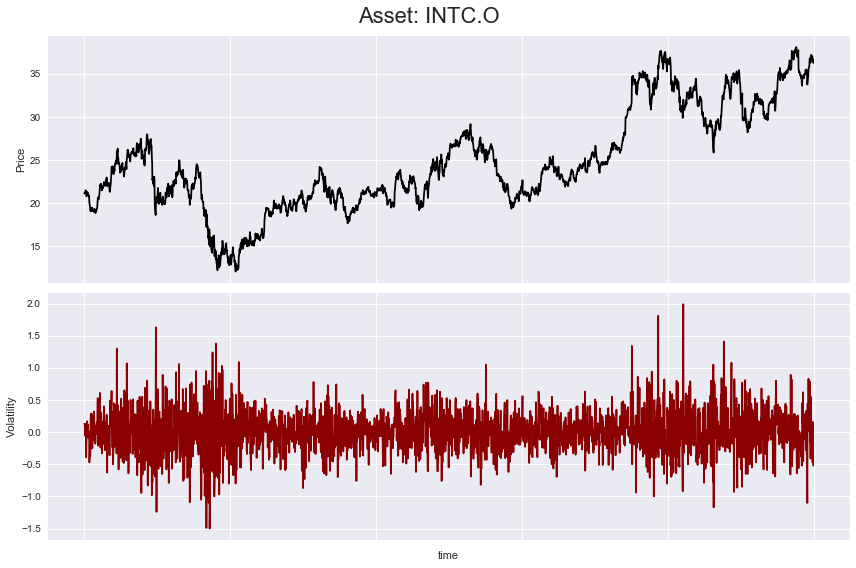

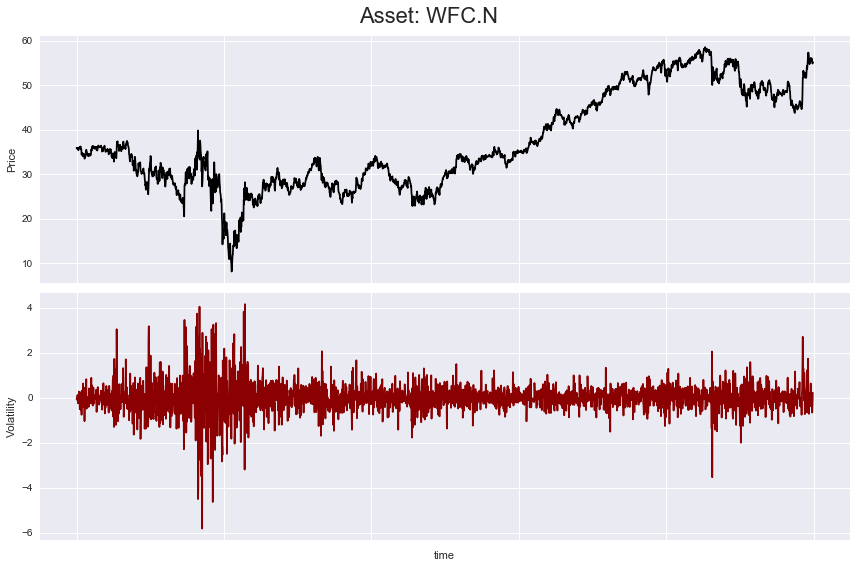

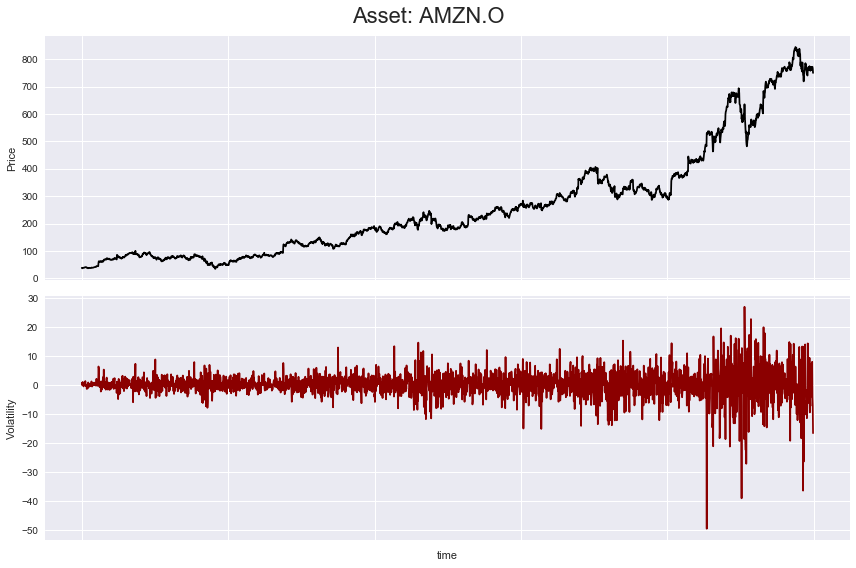

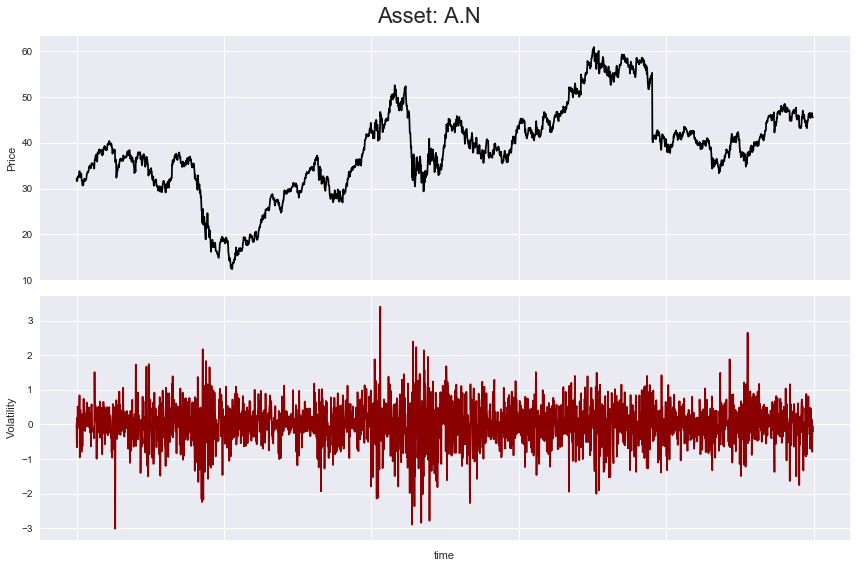

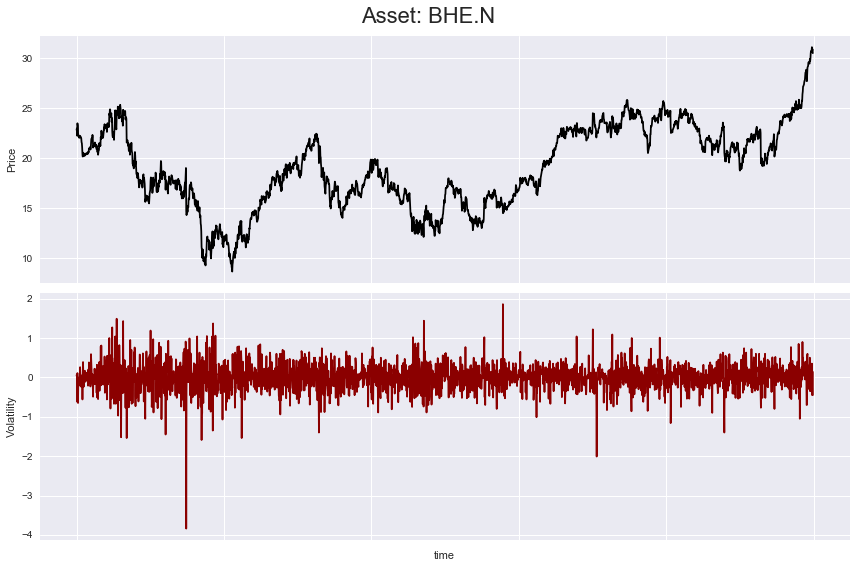

In [133]:
plot_chosen_assets()

In [139]:
X_train_INTC, y_train_INTC = extract_stock(X_train, y_train, "INTC.O")
X_train_WFC, y_train_WFC = extract_stock(X_train, y_train, "WFC.N")
X_train_AMZN, y_train_AMZN = extract_stock(X_train, y_train, "AMZN.O")
X_train_A, y_train_A = extract_stock(X_train, y_train, "A.N") 
X_train_BHE, y_train_BHE = extract_stock(X_train, y_train, "BHE.N") 